In [15]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from collections import defaultdict
import numpy as np
from tensorflow.keras.utils import to_categorical
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import cv2
from keras import regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

"""
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)
"""

"\nfrom tflite_model_maker.config import QuantizationConfig\nfrom tflite_model_maker.config import ExportFormat\nfrom tflite_model_maker import model_spec\nfrom tflite_model_maker import object_detector\n\nassert tf.__version__.startswith('2')\n\ntf.get_logger().setLevel('ERROR')\nfrom absl import logging\nlogging.set_verbosity(logging.ERROR)\n"

**LOADING THE IMAGES**

In [17]:
image_dir = 'dataset/images'
annotation_dir = 'dataset/annotations'

data=[]

for filename in os.listdir(annotation_dir):
    tree = ET.parse(os.path.join(annotation_dir, filename))
    root = tree.getroot()

    name = root[1].text
    label = root[4][0].text
    data.append((name, root[4][0].text))

**FILTERING THE IMAGES**

In [18]:
class_images = defaultdict(list)
for image, classname in data:
    class_images[classname].append((image, classname))

filtered_data=[]
for classname, images in class_images.items():
    filtered_data.extend(images[:61])

**CONVERTING TO ARRAYS AND SHUFFLING**

In [19]:
images=[]
labels=[]
count=0
for image_name, class_name in filtered_data:
    """
    try:
        image = cv2.imread(image_name)
        image = cv2.resize(image, (4, 4))
        images.append(image)
    except:
        count+=1
        print(image_name, " didn't work: ", count)
        continue
    """
    image = cv2.imread("dataset/images/"+image_name)
    image = cv2.resize(image, (256, 256))
    images.append(image)
    labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

images, labels = shuffle(images, labels, random_state=42)

**NORMALIZING & FLATTENING IMAGES**

In [20]:
images = images / 255.0

In [85]:
images = images.reshape(len(images), -1).astype("float32")

In [21]:
images.shape

(244, 256, 256, 3)

**ENCODE LABELS**

In [22]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [23]:
labels_encoded

array([3, 3, 0, 2, 2, 0, 2, 0, 3, 1, 3, 2, 1, 0, 1, 0, 2, 3, 1, 0, 3, 3, 1, 3, 2, 1, 3, 1, 0, 0, 1, 2, 3, 3, 3, 1, 1, 2, 0, 2, 1, 0, 1, 3, 2, 1, 0, 3, 2, 2, 2, 1, 0, 1, 3, 1, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 3, 2, 2, 0, 3, 3, 0, 0, 1, 1, 0, 2, 0, 3, 3, 3, 3, 3, 2, 0, 1, 0, 3, 1, 0, 2, 1, 3, 1, 2, 1,
       0, 3, 2, 2, 2, 2, 3, 3, 1, 3, 1, 0, 0, 0, 1, 1, 0, 0, 1, 3, 0, 1, 3, 1, 0, 0, 3, 2, 3, 0, 3, 0, 3, 0, 0, 0, 1, 0, 0, 2, 2, 1, 2, 1, 3, 2, 3, 0, 3, 0, 0, 1, 3, 2, 3, 1, 2, 3, 0, 2, 3, 1, 3, 0, 2, 2, 2, 3, 0, 1, 3, 2, 3, 0, 1, 1, 1, 2, 2, 1, 3, 3, 3, 2, 0, 3, 0, 1, 2, 0, 2, 2, 1, 3, 1, 3, 2, 0, 2, 2, 2, 2, 0, 3,
       3, 1, 3, 3, 2, 0, 2, 2, 2, 0, 3, 0, 2, 3, 3, 0, 0, 0, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 3, 2, 1, 1, 3, 1, 0, 1], dtype=int64)

**ONE-HOT ENCODE LABELS**

In [24]:
labels_one_hot = to_categorical(labels_encoded, num_classes=4)

**SPLITTING INTO TRAINING AND TESTING**

In [25]:
x_train, x_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

**MODEL ARCHITECTURE**

In [26]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.optimizer.get_config()

{'name': 'Adam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': False,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

**Train Model**

In [12]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
7/7 [==============================] - 8s 993ms/step - loss: 2.9169 - accuracy: 0.2718 - val_loss: 1.8961 - val_accuracy: 0.2041
Epoch 2/25
7/7 [==============================] - 7s 934ms/step - loss: 1.4767 - accuracy: 0.2769 - val_loss: 1.3825 - val_accuracy: 0.2245
Epoch 3/25
7/7 [==============================] - 7s 952ms/step - loss: 1.3667 - accuracy: 0.2667 - val_loss: 1.4058 - val_accuracy: 0.2245
Epoch 4/25
7/7 [==============================] - 7s 971ms/step - loss: 1.3106 - accuracy: 0.3282 - val_loss: 1.4288 - val_accuracy: 0.2857
Epoch 5/25
7/7 [==============================] - 7s 947ms/step - loss: 1.0500 - accuracy: 0.5897 - val_loss: 2.6067 - val_accuracy: 0.2449
Epoch 6/25
7/7 [==============================] - 6s 911ms/step - loss: 1.1599 - accuracy: 0.6154 - val_loss: 1.6886 - val_accuracy: 0.2245
Epoch 7/25
7/7 [==============================] - 6s 909ms/step - loss: 0.8206 - accuracy: 0.6615 - val_loss: 2.0894 - val_accuracy: 0.4286
Epoch 8/25
7/7 [====

In [13]:
val_loss, val_accuracy = model.evaluate(x_test, y_test)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

2/2 [==============================] - 0s 99ms/step - loss: 3.5855 - accuracy: 0.6327
Validation Loss: 3.585512161254883
Validation Accuracy: 0.6326530575752258


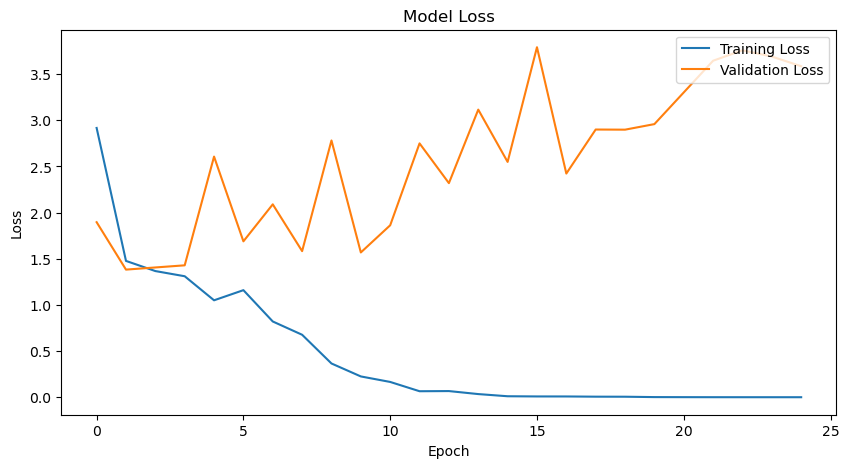

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [57]:
image = cv2.imread("test/traffictest3.png") #stoptest3, traffictest, 
image = cv2.resize(image, (128, 128))
image = image / 255.0
image = np.reshape(image, (1, 128, 128, 3))

In [61]:
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)
class_names = label_encoder.inverse_transform(predicted_class)

print(class_names[0])

1/1 [==============================] - 0s 32ms/step
trafficlight


In [15]:
def detect_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = np.reshape(image, (1, 128, 128, 3))

    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)
    class_names = label_encoder.inverse_transform(predicted_class)

    return class_names[0]

In [16]:
detect_image("test/traffictest3.png")

1/1 [==============================] - 0s 107ms/step


'trafficlight'

**Text To Speech**

In [17]:
import pyttsx3

def text_to_speech(text):
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()

In [21]:
text_to_speech(detect_image("test/traffictest3.png"))

1/1 [==============================] - 0s 18ms/step


**All Together**

In [22]:
def auditory_classification(image_path):
    text_to_speech(detect_image(image_path))

In [27]:
auditory_classification("test/stoptest3.png")

1/1 [==============================] - 0s 17ms/step


**PRETRAINED MODEL**

In [93]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=Input(shape=(256, 256, 3)))

In [94]:
base_model_output = base_model.layers[40].output

pretrained_model = Model(inputs=base_model.input, outputs=base_model_output)

**YOLO MODEL**

In [2]:
from ultralytics import YOLO

In [4]:
yolo_model = YOLO("yolov8n.pt")

In [5]:
yolo_model.train(data = "/Users/arham/Capstone/Road Signs.v1i.yolov8/data.yaml", epochs=6)

New https://pypi.org/project/ultralytics/8.2.71 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.70  Python-3.8.19 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i9-13950HX)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/arham/Capstone/Road Signs.v1i.yolov8/data.yaml, epochs=6, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

train: Scanning C:\Users\arham\Capstone\Road Signs.v1i.yolov8\train\labels.cache... 1839 images, 0 backgrounds, 0 corru
val: Scanning C:\Users\arham\Capstone\Road Signs.v1i.yolov8\valid\labels.cache... 174 images, 0 backgrounds, 0 corrupt:


Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train10
Starting training for 6 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/6         0G      1.159      2.218      1.123         30        640: 100%|██████████| 115/115 [05:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<0

                   all        174        237      0.661      0.677      0.709      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/6         0G      1.132      1.469       1.11         32        640: 100%|██████████| 115/115 [04:37<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<0

                   all        174        237      0.754      0.719      0.777      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/6         0G       1.12      1.227      1.114         24        640: 100%|██████████| 115/115 [04:47<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<0

                   all        174        237      0.866      0.747      0.815      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/6         0G      1.071      1.064      1.106         47        640: 100%|██████████| 115/115 [04:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<0

                   all        174        237      0.773      0.766      0.792      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/6         0G     0.9966     0.8939      1.061         40        640: 100%|██████████| 115/115 [04:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<0

                   all        174        237      0.945      0.827        0.9      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        6/6         0G     0.9624     0.7931      1.042         23        640: 100%|██████████| 115/115 [04:43<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<0

                   all        174        237      0.958      0.842      0.918      0.678



6 epochs completed in 0.496 hours.
Optimizer stripped from runs\detect\train10\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train10\weights\best.pt, 6.2MB

Validating runs\detect\train10\weights\best.pt...
Ultralytics YOLOv8.2.70  Python-3.8.19 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i9-13950HX)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:09<0


                   all        174        237      0.953      0.842      0.918      0.678
             crosswalk         37         46       0.95       0.83       0.96       0.65
            speedlimit        134        154      0.992      0.968      0.994      0.835
                  stop         16         16      0.986          1      0.995      0.828
          trafficlight         16         21      0.885      0.571      0.722      0.399
Speed: 0.5ms preprocess, 48.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\train10


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000024FBECAB7F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [27]:
def display_images(post_training_files_path, image_files):

    for image_file in image_files:
        image_path = os.path.join(post_training_files_path, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(10, 10), dpi=120)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# List of image files to display
image_files = [
    'confusion_matrix_normalized.png',
    'F1_curve.png',
    'P_curve.png',
    'R_curve.png',
    'PR_curve.png',
    'results.png'
]

# Path to the directory containing the images
post_training_files_path = 'runs/detect/train10/'

# Display the images
display_images(post_training_files_path, image_files)

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

In [29]:
#prediction = yolo_model.predict("test/stoptest2.png", show=True)[0].boxes
prediction = yolo_model.predict("stoptest.png", show=True)

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [30]:
new_model = YOLO('runs/detect/train10/weights/best.pt')

In [31]:
new_model.predict("stoptest.png", show=True)

WARNING  Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


image 1/1 C:\Users\arham\Capstone\stoptest.png: 640x640 1 stop, 261.6ms
Speed: 7.6ms preprocess, 261.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'crosswalk', 1: 'speedlimit', 2: 'stop', 3: 'trafficlight'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
        

In [23]:
"""
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="9ZEhbFWEaO6fW5Fc6CYk")
project = rf.workspace("arham-siddiqui").project("road-signs-jj0ea")
version = project.version(1)
dataset = version.download("yolov8")
"""

   ---------------------------------------- 0.0/76.9 kB ? eta -:--:--
   ---------------------------------------- 76.9/76.9 kB 2.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/178.7 kB ? eta -:--:--
   --------------------------------------- 178.7/178.7 kB 11.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   - -------------------------------------- 1.4/38.8 MB 28.8 MB/s eta 0:00:02
   ---- ----------------------------------- 4.3/38.8 MB 45.2 MB/s eta 0:00:01
   -------- ------------------------------- 8.7/38.8 MB 61.4 MB/s eta 0:00:01
   ------------ --------------------------- 11.8/38.8 MB 65.2 MB/s eta 0:00:01
   -------------- ------------------------- 13.9/38.8 MB 65.6 MB/s eta 0:00:01
   ----------------- ---------------------- 17.2/38.8 MB 65.2 MB/s eta 0:00:01
   ---------------------- ----------------- 21.5/38.8 MB 65.6 MB/s eta 0:00:01
   ------------------------ --------------- 24.1/38.8 MB 72.6 MB/s eta 0:00:01
  

RoboflowError: {
    "error": {
        "message": "Unsupported get request. Workspace with ID \"arham-siddiqui\" does not exist or cannot be loaded due to missing permissions.",
        "status": 404,
        "type": "GraphMethodException",
        "hint": "You can see your available workspaces by issuing a GET request to /workspaces"
    }
}

**DETECTING LOCATION OF OBJECT IN IMAGE**